**Creating Spatial Adjacency Matrix for each Suburb**

In [2]:
import pandas as pd
import geopandas as gpd

In [27]:
suburbs_gdf = gpd.read_file("../data/geo/shpfile/LOCALITY_POLYGON.shp")
list(suburbs_gdf["LOCALITY"].values)

['MOLLONGGHIP',
 'NORTH BLACKWOOD',
 'BASALT',
 'LLANELLY',
 'MURRABIT WEST',
 'SPRINGFIELD (SEA LAKE)',
 'WAITCHIE',
 'STRATEN',
 'GOWANFORD',
 'KUNAT',
 'MURRABIT',
 'LAKE CHARM',
 'MYALL (KERANG)',
 'POMONAL',
 'KENLEY',
 'WANDOWN',
 'TOWAN',
 'BONNIE DOON',
 'TERIP TERIP',
 'EMERALD',
 'HEALESVILLE',
 'THALLOO',
 'PRINCETOWN',
 'MURRAWEE',
 'NATYA',
 'MUSK VALE',
 'PIANGIL',
 'BEVERFORD',
 'COCAMBA',
 'BRUCKNELL',
 'ADA',
 'WEST WODONGA',
 'LERDERDERG',
 'CASTLE DONNINGTON',
 'KORWEINGUBOORA',
 'ROBINVALE',
 'ROCKLYN',
 'STANLEY',
 'BUFFALO RIVER',
 'BARRAKEE',
 'SILVAN',
 'KOOLOONONG',
 'BULLARTO SOUTH',
 'BANNERTON',
 'FRENCH ISLAND',
 'WODONGA',
 'SANDRINGHAM',
 'MONBULK',
 'BROADLANDS',
 'METUNG',
 'NARRUNG',
 'NYRRABY',
 'GLENROY',
 'KIEWA',
 'GRENVILLE',
 'LAKE POWELL',
 'BOUNDARY BEND',
 'LACEBY',
 'DOOEN',
 'PIMPINIO',
 'HAVEN',
 'BRIGHTON',
 'LOWER NORTON',
 'HORSHAM',
 'BUNGALALLY',
 'DRUNG',
 'MCKENZIE CREEK',
 'GLENDONALD',
 'KYVALLEY',
 'SPEED',
 'ULTIMA',
 'TRESCO',
 

In [31]:
import geopandas as gpd
import numpy as np
from scipy.spatial import cKDTree
k = 5

# 1) Load suburbs and project to a metric CRS (meters)
if suburbs_gdf.crs is None or suburbs_gdf.crs.is_geographic:
    suburbs_gdf = suburbs_gdf.to_crs(3111)  # VIC metric; adjust if needed

# 2) Use centroids for nearest-neighbor search
centroids = suburbs_gdf.geometry.centroid
coords = np.column_stack([centroids.x, centroids.y])

# 3) KDTree: get the nearest other suburb (k=2; skip self at [:,1])
tree = cKDTree(coords)
dists, idxs = tree.query(coords, k=6)
nearest_idx = idxs[:, 1:]        # nearest other suburb index
nearest_dist_m = dists[:, 1:]    # distance in meters to nearest other suburb

# 4) Build a nearest-suburb mapping (use your name/id column)
name_col = "LOCALITY"  # change to your actual column
suburb_names = suburbs_gdf[name_col].tolist()
nearest_suburbs_by_name = {
    suburb_names[i]: list(
        zip(
            [suburb_names[j] for j in idx_row],    # neighbor names
            dist_row                               # matching distances
        )
    )
    for i, (idx_row, dist_row) in enumerate(zip(nearest_idx, nearest_dist_m))
}


# build column names
cols = [f"neighbor_{i+1}" for i in range(k)]

df_neighbors = (
    pd.DataFrame.from_dict(nearest_suburbs_by_name, orient="index")
    .iloc[:, :k]  # just in case some lists are longer
    .set_axis(cols, axis=1)
    .rename_axis("suburb")
    .reset_index()
)

df_neighbors.head()

,suburb,neighbor_1,neighbor_2,neighbor_3,neighbor_4,neighbor_5
0,MOLLONGGHIP,"(ROCKLYN, 3581.6783617685)","(BARKSTEAD, 5112.977817535254)","(DEAN, 5655.445908354546)","(CLARETOWN, 5791.793172209908)","(BULLAROOK, 5912.662413637704)"
1,NORTH BLACKWOOD,"(TRENTHAM EAST, 3494.2423289512035)","(TRENTHAM, 4989.125030380734)","(BARRYS REEF, 6228.475895469958)","(FERN HILL, 6806.431415276523)","(NEWBURY, 6881.401736031668)"
2,BASALT,"(HEPBURN, 2188.906580747685)","(ELEVATED PLAINS, 3060.2551791008445)","(SHEPHERDS FLAT, 3662.815869185455)","(HEPBURN SPRINGS, 3736.1011565495974)","(DRY DIGGINGS, 5152.962321160329)"
3,LLANELLY,"(TARNAGULLA, 5751.849152227316)","(ARNOLD, 6142.7344175566095)","(ARNOLD WEST, 7457.34599858082)","(MURPHYS CREEK, 7475.316184639746)","(NEWBRIDGE, 8146.6739503373665)"
4,MURRABIT WEST,"(GONN CROSSING, 4074.037812045385)","(BENJEROOP, 5425.375650080507)","(MURRABIT, 6310.258535531165)","(LAKE CHARM, 11055.729695651811)","(CAPELS CROSSING, 11402.874191071445)"


Spatial Connectivity Matrix (W):
Values represent spatial influence weights (row-normalized)
           Suburb_1  Suburb_2  Suburb_3  Suburb_4  Suburb_5  Suburb_6  \
Suburb_1      0.000     0.588     0.294     0.118     0.000     0.000   
Suburb_2      0.370     0.000     0.370     0.185     0.074     0.000   
Suburb_3      0.156     0.312     0.000     0.312     0.156     0.063   
Suburb_4      0.059     0.147     0.294     0.000     0.294     0.147   
Suburb_5      0.000     0.059     0.147     0.294     0.000     0.294   
Suburb_6      0.000     0.000     0.059     0.147     0.294     0.000   
Suburb_7      0.000     0.000     0.000     0.059     0.147     0.294   
Suburb_8      0.000     0.000     0.000     0.000     0.063     0.156   
Suburb_9      0.000     0.000     0.000     0.000     0.000     0.074   
Suburb_10     0.000     0.000     0.000     0.000     0.000     0.000   

           Suburb_7  Suburb_8  Suburb_9  Suburb_10  
Suburb_1      0.000     0.000     0.000      0.000

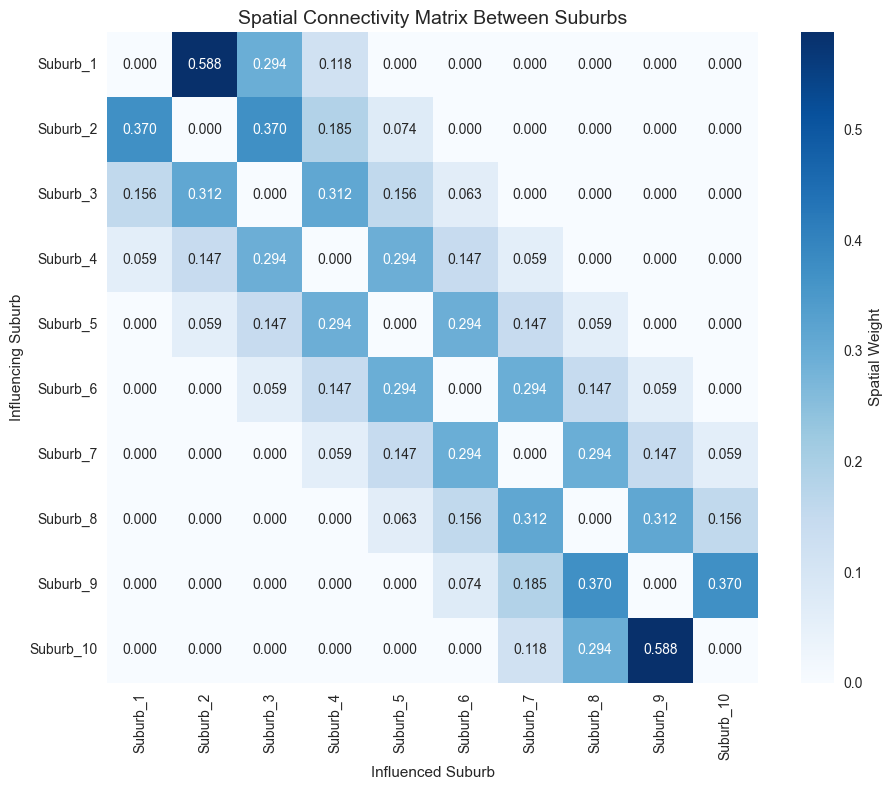

In [ ]:
# Create spatial connectivity matrix (W matrix)
# This represents spatial relationships between suburbs
# Higher values indicate stronger spatial influence

def create_spatial_matrix(n_units, connection_strength=0.4):
    """Create a spatial connectivity matrix with spatial continuity structure"""
    W = np.zeros((n_units, n_units))
    
    # Create spatial continuity: nearby suburbs influence each other
    for i in range(n_units):
        for j in range(n_units):
            if i != j:
                # Distance-based influence (decreasing with distance)
                distance = abs(i - j)
                if distance == 1:  # Adjacent suburbs
                    W[i, j] = connection_strength
                elif distance == 2:  # Second neighbors
                    W[i, j] = connection_strength * 0.5
                elif distance == 3:  # Third neighbors
                    W[i, j] = connection_strength * 0.2
                # Beyond distance 3: no direct influence
    
    # Row normalize (each row sums to 1)
    row_sums = W.sum(axis=1)
    row_sums[row_sums == 0] = 1  # Avoid division by zero
    W = W / row_sums[:, np.newaxis]
    
    return W

# Create the spatial connectivity matrix
W = create_spatial_matrix(n_spatial_units, connection_strength=0.4)

# Convert to DataFrame for better visualization
W_df = pd.DataFrame(W, index=suburbs, columns=suburbs)

print("Spatial Connectivity Matrix (W):")
print("Values represent spatial influence weights (row-normalized)")
print(W_df.round(3))

# Visualize the spatial connectivity matrix
plt.figure(figsize=(10, 8))
sns.heatmap(W_df, annot=True, cmap='Blues', fmt='.3f', 
            square=True, cbar_kws={'label': 'Spatial Weight'})
plt.title('Spatial Connectivity Matrix Between Suburbs', fontsize=14)
plt.xlabel('Influenced Suburb')
plt.ylabel('Influencing Suburb')
plt.tight_layout()
plt.show()


In [ ]:
# Create an adjacency matrix for each suburb
# Assuming you have a list of suburbs and their neighbours, e.g.:
# nearest_suburbs_by_name is a dictionary with 5 nearest neighbours for a given suburb

import numpy as np
import pandas as pd

n_spatial_units = len(suburbs_gdf)
eps = 0.0001

def create_spatial_matrix(n_units, connection_strength=0.4):
    """Create a spatial connectivity matrix with spatial continuity structure"""
    W = np.zeros((n_units, n_units))
    
    # Create spatial continuity: nearby suburbs influence each other
    for i in range(n_units):
        for j in range(n_units):
            if i != j:
                # Distance-based influence (decreasing with distance)
                distance = abs(i - j)
                if distance == 1:  # Adjacent suburbs
                    W[i, j] = connection_strength
                elif distance == 2:  # Second neighbors
                    W[i, j] = connection_strength * 0.5
                elif distance == 3:  # Third neighbors
                    W[i, j] = connection_strength * 0.2
                # Beyond distance 3: no direct influence
    
    # Row normalize (each row sums to 1)
    row_sums = W.sum(axis=1)
    row_sums[row_sums == 0] = 1  # Avoid division by zero
    W = W / row_sums[:, np.newaxis]
    
    return W

# Create the spatial connectivity matrix
W = create_spatial_matrix(n_spatial_units, connection_strength=0.4)

# Create a DataFrame to hold the adjacency matrix for each suburb
matrix = pd.DataFrame(
        0, index=suburbs, columns=suburbs
    )

for suburb, neighbours in nearest_suburb_by_name.items():
    for name, distance in neighbours:
        matrix.loc[suburb, name] = connection_strength / distance + eps
        matrix.loc[name, suburb] = connection_strength / distance + eps




In [38]:
# Create a DataFrame to hold the adjacency matrix for each suburb
suburbs_list = list(suburbs_gdf["LOCALITY"].values)
connection_strength = 0.4
eps = 0.0001
matrix = pd.DataFrame(
        0.0, index=suburbs_list, columns=suburbs_list
    )

for suburb, neighbours in nearest_suburbs_by_name.items():
    for name, distance in neighbours:
        if suburb == name or distance == 0:
            continue  # skip self matches
        matrix.loc[suburb, name] = connection_strength / distance + eps
        matrix.loc[name, suburb] = connection_strength / distance + eps


matrix.head()

,MOLLONGGHIP,NORTH BLACKWOOD,BASALT,LLANELLY,MURRABIT WEST,SPRINGFIELD (SEA LAKE),WAITCHIE,STRATEN,GOWANFORD,KUNAT,...,PORT MELBOURNE,EXFORD,THOMASTOWN,WATSONIA,BACCHUS MARSH,CHRISTMAS HILLS,YARRA GLEN,HEIDELBERG WEST,RESERVOIR,PARWAN
MOLLONGGHIP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NORTH BLACKWOOD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BASALT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LLANELLY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MURRABIT WEST,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Spatial Connectivity Matrix (W):
Values represent spatial influence weights (row-normalized)
                 MOLLONGGHIP  NORTH BLACKWOOD  BASALT  LLANELLY  \
MOLLONGGHIP              0.0              0.0     0.0       0.0   
NORTH BLACKWOOD          0.0              0.0     0.0       0.0   
BASALT                   0.0              0.0     0.0       0.0   
LLANELLY                 0.0              0.0     0.0       0.0   
MURRABIT WEST            0.0              0.0     0.0       0.0   
...                      ...              ...     ...       ...   
CHRISTMAS HILLS          0.0              0.0     0.0       0.0   
YARRA GLEN               0.0              0.0     0.0       0.0   
HEIDELBERG WEST          0.0              0.0     0.0       0.0   
RESERVOIR                0.0              0.0     0.0       0.0   
PARWAN                   0.0              0.0     0.0       0.0   

                 MURRABIT WEST  SPRINGFIELD (SEA LAKE)  WAITCHIE  STRATEN  \
MOLLONGGHIP              

KeyboardInterrupt: 

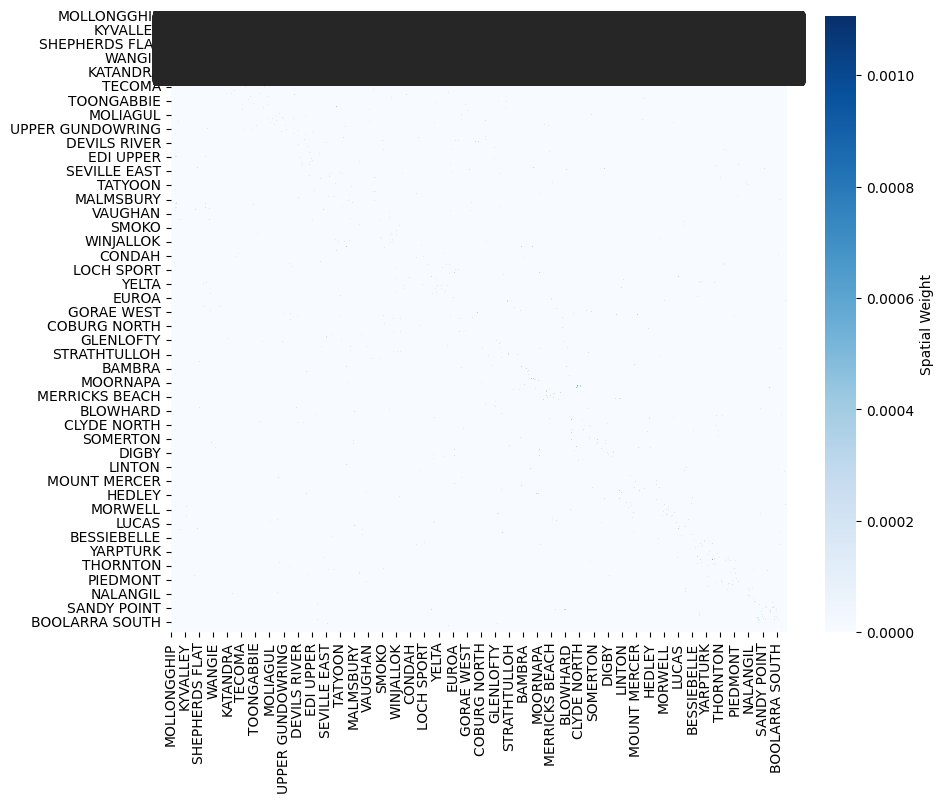

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

print("Spatial Connectivity Matrix (W):")
print("Values represent spatial influence weights (row-normalized)")
print(matrix.round(3))

# Visualize the spatial connectivity matrix
plt.figure(figsize=(10, 8))
sns.heatmap(matrix, annot=True, cmap='Blues', fmt='.3f', 
            square=True, cbar_kws={'label': 'Spatial Weight'})
plt.title('Spatial Connectivity Matrix Between Suburbs', fontsize=14)
plt.xlabel('Influenced Suburb')
plt.ylabel('Influencing Suburb')
plt.tight_layout()
plt.show()